In [1]:
from forward import solve_forward
from simulation import Simulation
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
# to load large .mat files
import mat73
import random
from net import EEG_CNN

2021-12-23 20:58:14.390672: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-23 20:58:14.390743: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Train the CNN

In [2]:
eeg_topos = mat73.loadmat('/media/thanos/Elements/thanos/sim_data/sim_type_1/eeg_topos_2TeD.mat')['eeg_topos']
eeg_topos = eeg_topos.transpose(2, 0, 1)

Text(0.5, 1.0, 'Topography for eeg signal: 4940')

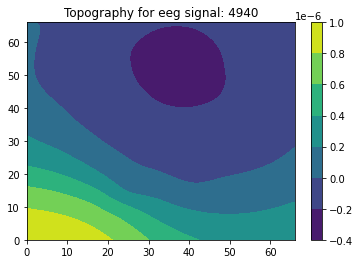

In [3]:
topo_idx = random.randint(0,eeg_topos.shape[0]-1)
topo = eeg_topos[topo_idx,:,:]
plt.contourf(topo, cmap=cm.get_cmap('viridis'))
cbar = plt.colorbar()
plt.draw()
plt.title('Topography for eeg signal: {}'.format(topo_idx+1))

In [4]:
# load previous simulation
sources = np.load('/media/thanos/Elements/thanos/sim_data/sim_type_1/sources_2TeD.npy')
eeg = np.load('/media/thanos/Elements/thanos/sim_data/sim_type_1/eeg_2TeD.npy')

fwd = solve_forward()
sim = Simulation(fwd=fwd, source_data=sources, eeg_data=eeg)
# fwd = solve_forward()
# sim = Simulation(fwd=fwd)
# sim.simulate(n_samples=100)

Forward problem is solved.
Electrodes: (73, 3)
Dipoles: (50460, 3)
Leadfield: (73, 50460)


In [5]:
eegcnn = EEG_CNN(sim=sim, eeg_topographies=eeg_topos)

In [6]:
# eegcnn.build_model()
eegcnn.load_nn('/media/thanos/Elements/thanos/nn_trained/cnn_model.h5')

2021-12-23 21:08:35.405011: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-23 21:08:35.407111: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-23 21:08:35.408774: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (thanos): /proc/driver/nvidia/version does not exist
2021-12-23 21:08:35.428113: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-23 21:08:36.282249: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 276889600 exceeds 10

Loaded model in EEG_CNN :
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 65, 65, 32)        320       
                                                                 
 flatten (Flatten)           (None, 135200)            0         
                                                                 
 dense (Dense)               (None, 512)               69222912  
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 1024)              525312    
                                                                 
 batch_normalization_1 (Batc  (None, 1024)             4096      
 hNormalization)              

In [7]:
eegcnn.fit(epochs=380, patience=70, batch_size=128)

Epoch 1/380
631/631 [==============================] - 1537s 2s/step - loss: 4.5098e-05 - val_loss: 4.1810e-05
Epoch 2/380
631/631 [==============================] - 1432s 2s/step - loss: 4.7800e-05 - val_loss: 7.6407e-05
Epoch 3/380
631/631 [==============================] - 1449s 2s/step - loss: 4.9925e-05 - val_loss: 4.6169e-05
Epoch 4/380
631/631 [==============================] - 1448s 2s/step - loss: 5.0331e-05 - val_loss: 5.6704e-05
Epoch 5/380
631/631 [==============================] - 1418s 2s/step - loss: 5.0950e-05 - val_loss: 6.8267e-05
Epoch 6/380
631/631 [==============================] - 1413s 2s/step - loss: 5.1360e-05 - val_loss: 4.8518e-05
Epoch 7/380
631/631 [==============================] - 1414s 2s/step - loss: 4.8916e-05 - val_loss: 7.3926e-05
Epoch 8/380
631/631 [==============================] - 1413s 2s/step - loss: 4.9374e-05 - val_loss: 6.6789e-05
Epoch 9/380
631/631 [==============================] - 1407s 2s/step - loss: 4.9334e-05 - val_loss: 5.2197e-05
E

(<keras.callbacks.History at 0x7fa94ce4a580>,
 'logs/CNN-Model-23_12_2021__20:58:19')

In [8]:
eegcnn.save_nn('../cnn_model_2.h5')

### Evaluate the CNN

In [ ]:
eegcnn.load_nn('/media/thanos/Elements/thanos/nn_trained/cnn_model.h5')

In [ ]:
eeg_topos_eval = mat73.loadmat('/media/thanos/Elements/thanos/sim_data/sim_type_1/eval_100/eeg_topos_eval_100.mat')['eeg_topos']
eeg_topos_eval = eeg_topos_eval.transpose(2, 0, 1)

sources_eval = np.load('/media/thanos/Elements/thanos/sim_data/sim_type_1/eval_100/sources.npy')


In [ ]:
predicted_sources = eegcnn.predict(eeg=eeg_topos_eval).T

In [ ]:
np.save('../../Downloads/predicted_sources.npy',predicted_sources)